In [ ]:
import numpy as np
import os
from numpy import linalg as LA
import librosa
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras import backend as K
import pandas as pd
import cv2
from PIL import Image
import time
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
#from pylab import *
import math

## Import and save row datas

In [2]:
data_arr = []
levels=os.listdir("./BillData/")
for a in levels:
    try:
        if not a.startswith('.'):
            files = os.listdir("./BillData/"+a)
            files_arr = []
            for b in files:
                try:
                    if not b.startswith('.'):
                        num_arr = []
                        path_to_file = os.path.join("./BillData/"+a, b)
                        fd = open(path_to_file , 'r')
                        while True:
                            string = fd.readline()
                            if not string: break
                            num_arr.append(float(string[:-1]))
                        files_arr.append(num_arr)
                        fd.close()
                except AttributeError:
                    print("")
            data_arr.append(files_arr)
    except AttributeError:
        print("")
        
#data_arr[level_num][file_num][numbers]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#numbers : 0~8799(8800 amplitudes)

In [3]:
Datas=np.array(data_arr)

In [4]:
np.save("./npy/Datas",Datas)

## Load row datas

In [5]:
Datas=np.load("./npy/Datas.npy")

## 1. Statistical analysis

## Data preprocessing

In [6]:
file_static = []
for a in Datas:
    tmp = []
    for b in a:
        l = len(b)
        m = np.mean(b)
        s = np.std(b)
        sum1 = float(0)
        sum2 = float(0)
        for x in range(0,l):
            sum1 = sum1 + np.power(((b[x] - m)/s),3)
            sum2 = sum2 + np.power(((b[x] - m)/s),4)
        ske = sum1/l
        kur = sum2/l
        static = [s,ske,kur]
        tmp.append(static)
    file_static.append(tmp)
#file_static[level_num][file_num][static]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#static : {0:std,1:ske,2:kur}

In [7]:
level_static = []
for a in Datas:
    tmp = []
    for b in a:
        for c in b:
            tmp.append(c)
    l = len(tmp)
    m = np.mean(tmp)
    s = np.std(tmp)
    sum1 = float(0)
    sum2 = float(0)
    for x in range(0,l):
        sum1 = sum1 + np.power(((tmp[x] - m)/s),3)
        sum2 = sum2 + np.power(((tmp[x] - m)/s),4)
    ske = sum1/l
    kur = sum2/l
    static = [s,ske,kur]
    level_static.append(static)
#level_static[level_num][static]
#level_num : 0~4(5 classes)
#static : {0:std,1:ske,2:kur}

## Save processed datas

In [9]:
FS=np.array(file_static)
np.save("./npy/file_static",FS)
LS=np.array(level_static)
np.save("./npy/level_static",LS)

## Load processed datas

In [10]:
FS=np.load("./npy/file_static.npy")
LS=np.load("./npy/level_static.npy")

## 1-1. Euclidean distance

In [11]:
ED = []
for a in range(0,len(FS)):
    tmp_1 = []
    for b in FS[a]:
        tmp_2 = []
        for c in LS:
            tmp_2.append(LA.norm(c-b))
        mm=min(tmp_2)
        for i in range(0,len(tmp_2)):
            if(tmp_2[i] == mm):
                tmp_2.append(i)
                if(i == a):
                    tmp_2.append(1)
                else:
                    tmp_2.append(0)
        tmp_1.append(tmp_2)
    ED.append(tmp_1)
#ED[level_num][file_num][distance&result]
#level_num : 0~4(5 classes)
#file_num : 0~79(20*4 files)
#static : {0~4:distance by level,5:result,6:T/F}

In [12]:
count = 0
for a in range(0,len(ED)):
    cou = 0
    for b in ED[a]:
        if(b[6]==1):
            cou = cou + 1
            count = count + 1
    print("level{0}:{1}".format(a,cou/len(ED[0])*100))
print("all:{}".format(count/len(ED[0])/5*100))

level0:0.0
level1:88.75
level2:2.5
level3:13.750000000000002
level4:20.0
all:25.0


In [13]:
from sklearn.metrics import confusion_matrix
test = []
for i in range(0,5):
    for j in range(0,80):
        test.append(i)
pred = []
for a in range(0,len(ED)):
    for b in ED[a]:
        pred.append(b[5])

print(confusion_matrix(test, pred))

[[ 0 69  4  1  6]
 [ 0 71  0  0  9]
 [ 0 67  2  2  9]
 [ 6 34  3 11 26]
 [ 0 60  2  2 16]]


## Visualization of data

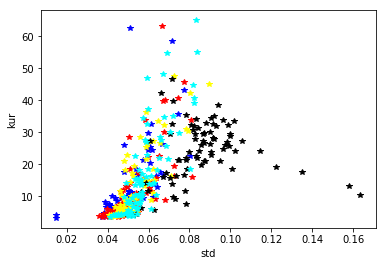

In [14]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
for a in range(0,len(FS)):
    color=["blue","red","yellow","black","cyan"]
    for b in FS[a] :
        plt.plot(b[0], b[2],c=color[a],marker="*")

plt.xlabel('std')
plt.ylabel('kur')


plt.show()

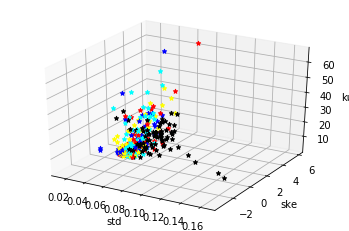

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for a in range(0,len(FS)):
    color=["blue","red","yellow","black","cyan"]
    for b in FS[a] :
        ax.scatter(b[0], b[1], b[2],c=color[a],marker="*")

ax.set_xlabel('std')
ax.set_ylabel('ske')
ax.set_zlabel('kur')

plt.show()

## 1-2. SVM

In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## Data processing

In [17]:
import numpy as np
import scipy

STATs = []
Label = []
for a in range(0,len(FS)):
    for b in FS[a]:
        STATs.append([b[0],b[2]])
        Label.append(a)

STATs=np.array(STATs)
Label=np.array(Label)
s=np.arange(STATs.shape[0])
np.random.shuffle(s)
STATs=STATs[s]
Label=Label[s]

## Learning and visualizing

Labels count in Y: [80 80 80 80 80]
Labels counts in Y_train: [56 56 56 56 56]
Labels counts in Y_train: [24 24 24 24 24]


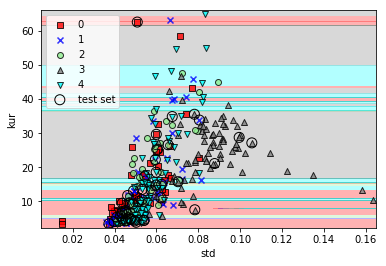

Misclassified samples: 82
Accuracy: 0.32


In [18]:
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(STATs ,Label, test_size=0.3, random_state=1, stratify=Label)
print('Labels count in Y:', np.bincount(Label))
print('Labels counts in Y_train:', np.bincount(Y_train))
print('Labels counts in Y_train:', np.bincount(Y_test))

from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=1, C=1.0)
svm.fit(X_train, Y_train)

plot_decision_regions(STATs, Label,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('std')
plt.ylabel('kur')
plt.legend(loc='upper left')
#plt.savefig('./svm.png', dpi=300)
plt.show()

Y_pred = svm.predict(X_test)
print('Misclassified samples: %d' % (Y_test != Y_pred).sum())

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_pred))

## Confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_pred))

[[ 4 10  1  8  1]
 [ 8  9  0  2  5]
 [ 2  7  5  8  2]
 [ 0  5  1 15  3]
 [ 1  5  0 13  5]]


## 1-3 Classifier

In [20]:
import numpy as np
import scipy

STATs = []
Label = []
file_static = []
for a in range(0,len(FS)):
    for b in FS[a]:
        STATs.append(b)
        Label.append(a)

STATs=np.array(STATs)
Label=np.array(Label)

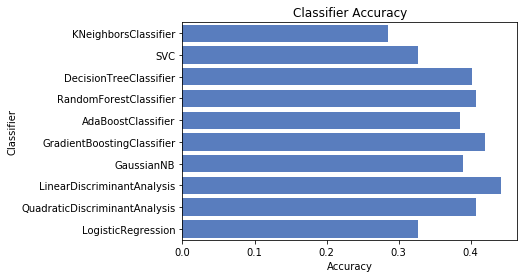

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = STATs
y = Label

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./ST.pdf', dpi=600)

## 2.Difference

## 2-1. AMP by time

In [44]:
Diff_t=[]
la_t = []
for for_1 in range(0,len(Datas)): 
    for for_2 in range(0,len(Datas[0])):   
        tmp = np.zeros(51)
        _X_ = Datas[for_1][for_2][2:]-Datas[for_1][for_2][1:8799]
        _Y_ = Datas[for_1][for_2][1:8799]-Datas[for_1][for_2][:8798]
        _R_ = np.sqrt(_X_*_X_ + _Y_*_Y_)
        for a in _R_:
            if(0<=a<=0.125):
                tmp[int(a/0.0025)] = tmp[int(a/0.0025)] + 1
            elif(a>0.125):
                tmp[50] = tmp[50] + 1
        Diff_t.append(tmp)
        la_t.append(for_1)

In [45]:
Diff_t = np.array(Diff_t)
la_t = np.array(la_t)

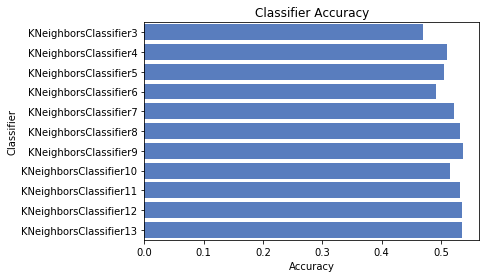

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    KNeighborsClassifier(4),
    KNeighborsClassifier(5),
    KNeighborsClassifier(6),
    KNeighborsClassifier(7),
    KNeighborsClassifier(8),
    KNeighborsClassifier(9),
    KNeighborsClassifier(10),
    KNeighborsClassifier(11),
    KNeighborsClassifier(12),
    KNeighborsClassifier(13),
    ]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = Diff_t
y = la_t

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    k=3
    for clf in classifiers:
        name = clf.__class__.__name__ + str(k)
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
        k = k+1

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./Diff.pdf', dpi=600)

## 2-2. AMP by Freq(Fourier transform)

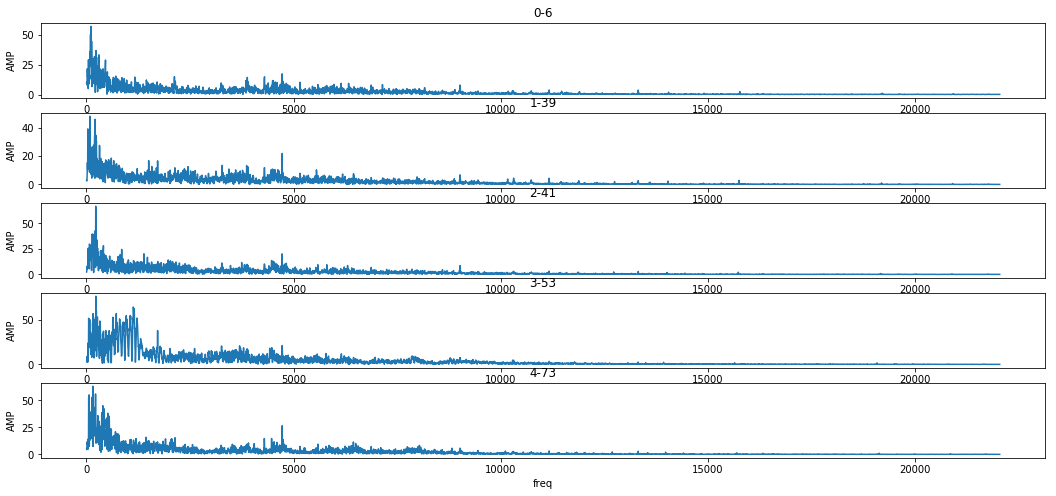

In [47]:
fig, ax = plt.subplots(5, 1, figsize=(18, 8))
for for_1 in range(0,len(Datas)):
    fi_nu = random.randrange(1,80)
    Y = np.fft.fft(Datas[for_1][fi_nu][:])
    N = int(len(Y)/2)
    Y[0] = None
    AMP = np.abs(Y[0:N])
    nyquist = 1/2*44100
    freq = np.arange(0, N, 1)/(N)*nyquist
    ax[for_1].plot(freq, AMP)
    ax[for_1].set_title(str(for_1) +"-"+ str(fi_nu+1))
    #ax[for_1].axis([-0.001,44101,-0.001,10000])
    ax[for_1].set_ylabel('AMP')
    ax[for_1].set_xlabel('freq')
#plt.savefig('./fft1.pdf', dpi=300)

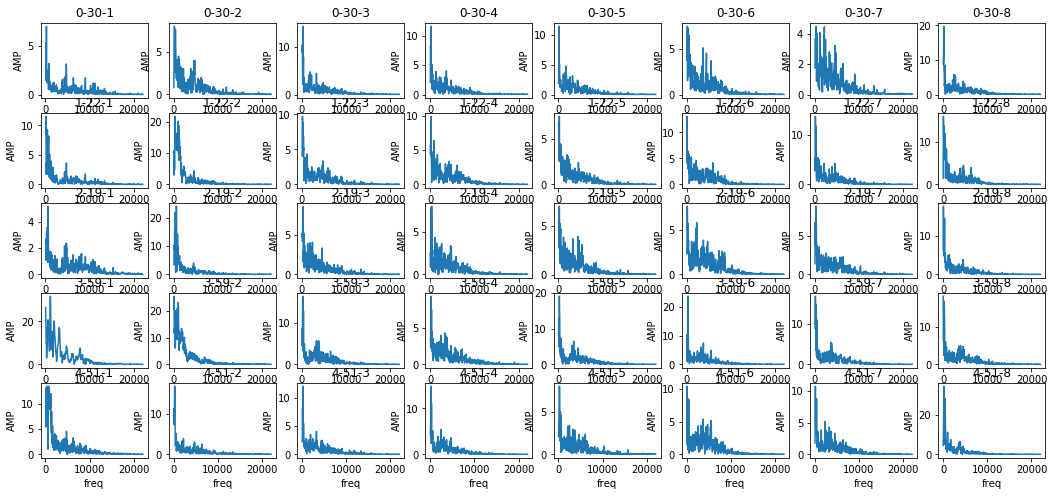

In [48]:
fig, ax = plt.subplots(5, 8, figsize=(18, 8))
for for_1 in range(0,len(Datas)):
    fi_nu = random.randrange(1,80)
    for for_2 in range(8):
        Y = np.fft.fft(Datas[for_1][fi_nu][for_2*1024+0:for_2*1024+1023])
        N = int(len(Y)/2)
        Y[0] = None
        AMP = np.abs(Y[0:N])
        nyquist = 1/2*44100
        freq = np.arange(0, N, 1)/(N)*nyquist
        ax[for_1][for_2].plot(freq, AMP)
        ax[for_1][for_2].set_title(str(for_1) +"-"+ str(fi_nu+1) +"-"+ str(for_2+1))
        #ax[for_1][for_2].axis([-0.001,44100,-0.001,500])
        ax[for_1][for_2].set_ylabel('AMP')
        ax[for_1][for_2].set_xlabel('freq')
        
#plt.savefig('./fft2.pdf', dpi=600)

In [49]:
Diff=[]
la = []
for for_1 in range(0,len(Datas)):
    for for_2 in range(0,len(Datas[0])):
        tmp = []
        for for_3 in range(7):
            Y = np.fft.fft(Datas[for_1][for_2][for_3*1024+0:for_3*1024+1023])
            Z = np.fft.fft(Datas[for_1][for_2][for_3*1024+512:for_3*1024+1535])
            W = np.fft.fft(Datas[for_1][for_2][for_3*1024+1024:for_3*1024+2047])
            N = int(len(Y)/2)
            Y[0] = None
            Z[0] = None
            W[0] = None
            _X_ = np.abs(np.abs(W[0:N])-np.abs(Z[0:N]))[1:256]
            _Y_ = np.abs(np.abs(Z[0:N])-np.abs(Y[0:N]))[1:256]
            _R_ = np.sum(_X_ + _Y_)
            tmp.append(_R_)
        Diff.append(tmp)
        la.append(for_1) 

In [50]:
Diff = np.array(Diff)
la = np.array(la)

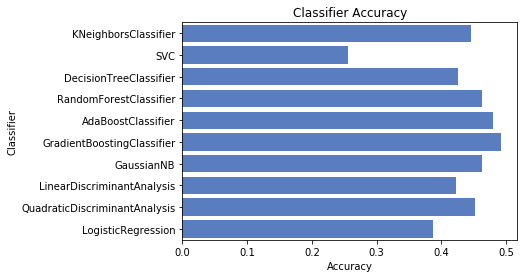

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = Diff
y = la

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
#plt.savefig('./Diff_f.pdf', dpi=600)